In [1]:
!pip install tensorflow-macos tensorflow-metal opencv-python-headless scikit-learn matplotlib seaborn

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow and Machine Learning Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Configure GPU (if available)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.2
Num GPUs Available: 1


In [3]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    
    for label in ['first_print', 'second_print']:
        path = os.path.join(folder_path, label)
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label)
    
    return np.array(images), np.array(labels)

dataset_path = '/Users/handsoham/Desktop/Almeno/Almeno Project/dataset'

X, y = load_images_from_folder(dataset_path)

print("Total number of images:", len(X))
print("Image shape:", X[0].shape)
print("Label distribution:", np.unique(y, return_counts=True))

Total number of images: 200
Image shape: (224, 224)
Label distribution: (array(['first_print', 'second_print'], dtype='<U12'), array([100, 100]))


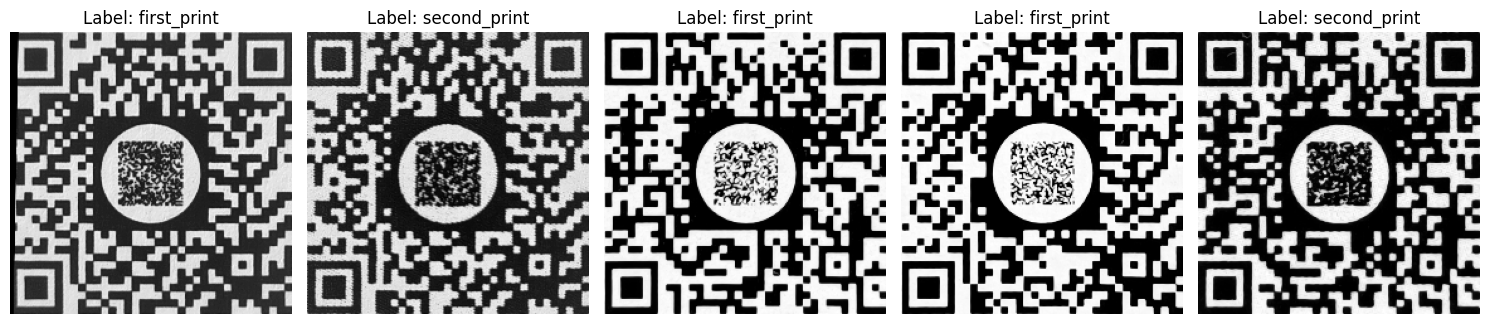

In [4]:
X = X / 255.0

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 224, 224, 1)
X_test = X_test.reshape(X_test.shape[0], 224, 224, 1)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {label_encoder.classes_[y_train[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def create_metal_optimized_cnn(input_shape=(224, 224, 1)):
    """
    Create a CNN model optimized for Apple Metal GPU
    
    Args:
        input_shape (tuple): Shape of input images
    
    Returns:
        tensorflow.keras.Model: Compiled CNN model
    """
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', 
                               input_shape=input_shape,
                               padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tf.keras.mixed_precision.set_global_policy('mixed_float16')

metal_cnn_model = create_metal_optimized_cnn()

metal_cnn_model.summary()

/opt/miniconda3/envs/tvrenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-29 04:37:30.776398: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-29 04:37:30.776423: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-29 04:37:30.776430: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-29 04:37:30.776450: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-29 04:37:30.776466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.c

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,193 (98.36 MB)

 Trainable params: 25,783,745 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
history = metal_cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=200,
    validation_data=(X_test, y_test),
    verbose=1
)

y_pred = metal_cnn_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                            target_names=label_encoder.classes_))

/opt/miniconda3/envs/tvrenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


2025-03-29 04:37:32.297528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5512 - loss: 1.4672 - val_accuracy: 0.4250 - val_loss: 0.6974
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4465 - loss: 2.4004 - val_accuracy: 0.4750 - val_loss: 0.6961
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5206 - loss: 2.6675 - val_accuracy: 0.5250 - val_loss: 0.8127
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5855 - loss: 4.1149 - val_accuracy: 0.5250 - val_loss: 0.7160
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5543 - loss: 4.4759 - val_accuracy: 0.5500 - val_loss: 0.6796
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6000 - loss: 5.2116 - val_accuracy: 0.5500 - val_loss: 0.6759
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.6359 - loss: 4.2548 - val_accuracy: 0.5250 - val_loss: 0.7614
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7086 - loss: 4.3690 - val_accuracy: 0.5250 - val_loss: 1.0388
Epoch 9/200
3/3 ━━━━

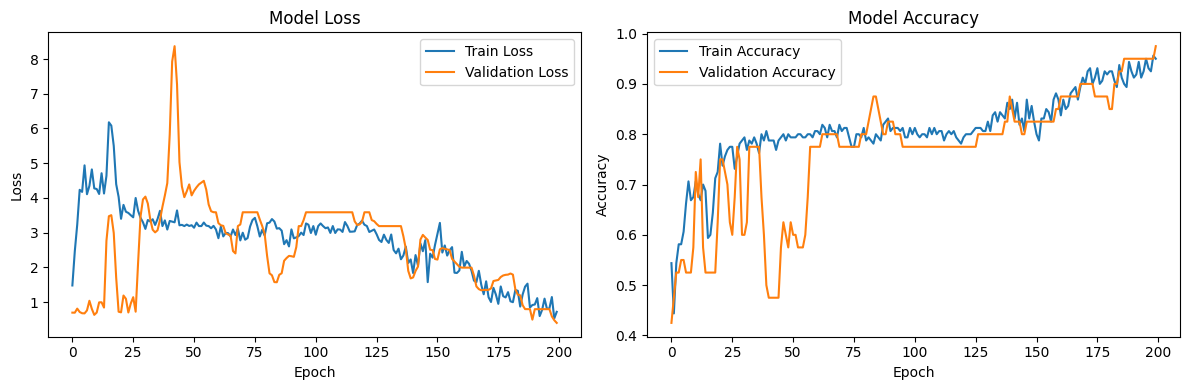

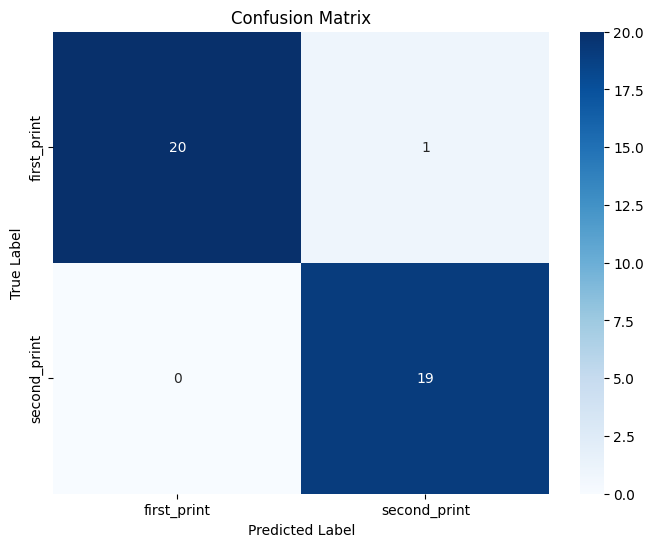

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [8]:
os.makedirs('saved_models', exist_ok=True)

model_save_path = 'saved_models/qr_code_authentication_model_new.keras'
metal_cnn_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to saved_models/qr_code_authentication_model_new.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: second_print
Prediction probability: 1.0000


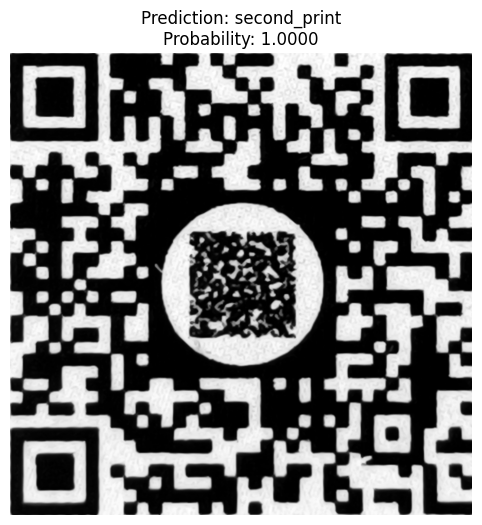

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(224, 224)):

    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Resize to match training dimensions
    img = cv2.resize(img, target_size)
    
    # Normalize pixel values (0-255 to 0-1)
    img = img / 255.0
    
    # Reshape for model input (add batch and channel dimensions)
    img = img.reshape(1, 224, 224, 1)
    
    return img

def predict_qr_code(model_path, image_path):
    # Load the model
    try:
        model = load_model(model_path)
    except Exception as e:
        raise ValueError(f"Error loading model: {str(e)}")
    
    # Preprocess the input image
    processed_image = load_and_preprocess_image(image_path)
    
    # Make prediction
    prediction = model.predict(processed_image)
    probability = prediction[0][0]
    
    # Convert probability to class (0 = first_print, 1 = second_print)
    class_predicted = 'second_print' if probability > 0.5 else 'first_print'
    
    return probability, class_predicted

def display_result(image_path, probability, predicted_class):
    """
    Display the input image with prediction results
    
    Args:
        image_path (str): Path to the input image
        probability (float): Prediction probability
        predicted_class (str): Predicted class label
    """
    # Load original image for display
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Create figure
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f'Prediction: {predicted_class}\nProbability: {probability:.4f}')
    plt.axis('off')
    plt.show()

def main():
    model_path = 'saved_models/qr_code_authentication_model_new.keras'
    image_path = 'dataset/second_print/input_image_create (5).png'
    
    try:
        probability, predicted_class = predict_qr_code(model_path, image_path)
        
        print(f"Predicted class: {predicted_class}")
        print(f"Prediction probability: {probability:.4f}")
        
        display_result(image_path, probability, predicted_class)
        
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()